In [49]:
import datetime
import pandas as pd

import holidays
from sklearn.cluster import HDBSCAN, KMeans
import pandas as pd

co_hol = holidays.Colombia()

Winter = [5, 6, 7, 8, 9, 10, 11]
Summer = [1, 2, 3, 4, 12]

In [50]:
df = pd.read_excel('data/Generacion_(kWh)_2024.xlsx', engine='openpyxl', parse_dates=["Fecha"])
df_ = df.set_index([
    col for col in df.columns if col not in [str(h) for h in range(24)]
])
df_.columns = range(24)
df_ = df_.stack().reset_index()
df_.rename(columns={'level_10': "hours", 0: "generacion"}, inplace=True)
df_["datetime"] = pd.to_datetime(df_["Fecha"]) + pd.to_timedelta(df_["hours"], unit='h')
df_ = df.set_index([
    col for col in df.columns if col not in [str(h) for h in range(24)]
])
df_.columns = range(24)
df_ = df_.stack().reset_index()
df_.rename(columns={'level_10': "hours", 0: "generacion"}, inplace=True)
df_["datetime"] = pd.to_datetime(df_["Fecha"]) + pd.to_timedelta(df_["hours"], unit='h')
df_

,Fecha,Recurso,Código Recurso,Tipo Generación,Combustible,Código Agente,Tipo Despacho,Es Menor,Clasificación,Version,hours,generacion,datetime
0,2024-01-01,AGPE - ECOPETROL LA HORMIGA,2XXR,TERMICA,GAS,GECG,NO DESPACHADO CENTRALMENTE,NO,AUTOG PEQ. ESCALA,TX5,0,548.57,2024-01-01 00:00:00
1,2024-01-01,AGPE - ECOPETROL LA HORMIGA,2XXR,TERMICA,GAS,GECG,NO DESPACHADO CENTRALMENTE,NO,AUTOG PEQ. ESCALA,TX5,1,569.43,2024-01-01 01:00:00
2,2024-01-01,AGPE - ECOPETROL LA HORMIGA,2XXR,TERMICA,GAS,GECG,NO DESPACHADO CENTRALMENTE,NO,AUTOG PEQ. ESCALA,TX5,2,594.57,2024-01-01 02:00:00
3,2024-01-01,AGPE - ECOPETROL LA HORMIGA,2XXR,TERMICA,GAS,GECG,NO DESPACHADO CENTRALMENTE,NO,AUTOG PEQ. ESCALA,TX5,3,596.90,2024-01-01 03:00:00
4,2024-01-01,AGPE - ECOPETROL LA HORMIGA,2XXR,TERMICA,GAS,GECG,NO DESPACHADO CENTRALMENTE,NO,AUTOG PEQ. ESCALA,TX5,4,573.26,2024-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154955,2024-11-22,ZIPAEMG 5,ZPA5,TERMICA,CARBON,ENDG,DESPACHADO CENTRALMENTE,NO,NORMAL,TX1,19,51209.35,2024-11-22 19:00:00
2154956,2024-11-22,ZIPAEMG 5,ZPA5,TERMICA,CARBON,ENDG,DESPACHADO CENTRALMENTE,NO,NORMAL,TX1,20,51756.12,2024-11-22 20:00:00
2154957,2024-11-22,ZIPAEMG 5,ZPA5,TERMICA,CARBON,ENDG,DESPACHADO CENTRALMENTE,NO,NORMAL,TX1,21,51715.82,2024-11-22 21:00:00
2154958,2024-11-22,ZIPAEMG 5,ZPA5,TERMICA,CARBON,ENDG,DESPACHADO CENTRALMENTE,NO,NORMAL,TX1,22,51697.37,2024-11-22 22:00:00


In [51]:

df_agg = df_.groupby(["Fecha", "Tipo Generación"]).agg({
    "generacion": "sum",
}).reset_index()
# }).reset_index()
df_agg["generacion"] = df_agg["generacion"]*1E-6 
df_agg = df_agg.pivot(index="Fecha", columns="Tipo Generación", values="generacion")
df_agg.columns.name=None
df_agg["TOTAL_GEN"] = df_agg.sum(axis=1)
# Generación in GWh
df_agg = df_agg.reset_index()

df_agg["day_of_week"] = df_agg["Fecha"].dt.dayofweek
# df_agg["week_of_year"] = df_agg["Fecha"].dt.isocalendar().week
df_agg["winter"] = df_agg["Fecha"].dt.month.apply(lambda x:  1 if x in Winter else 0)
# df_agg["is_holiday"] = df_agg["Fecha"].apply(lambda x: 1 if co_hol.get(x) else 0)
df_agg.fillna(0, inplace=True)

In [52]:
# ==== Add precio bolsa to cluster ===
precio_bolsa = pd.read_excel('data/Precio_Bolsa_Nacional_($kwh)_2024.xlsx', engine='openpyxl', parse_dates=["Fecha"])
precio_bolsa_ = precio_bolsa.set_index(["Fecha"]).stack().reset_index()
precio_bolsa_.columns = ["Fecha", "hours", "precio_bolsa"]
precio_bolsa_agg = precio_bolsa_.groupby(["Fecha"]).agg({"precio_bolsa":["max", "mean", "min"]}).reset_index()
precio_bolsa_agg.columns = ['_'.join(col).strip() for col in precio_bolsa_agg.columns.values]
precio_bolsa_agg.rename(columns={"Fecha_": "Fecha"}, inplace=True)

In [53]:
df_agg = df_agg.merge(precio_bolsa_agg, on="Fecha", how="inner")
df_agg

,Fecha,COGENERADOR,EOLICA,HIDRAULICA,SOLAR,TERMICA,TOTAL_GEN,day_of_week,winter,precio_bolsa_max,precio_bolsa_mean,precio_bolsa_min
0,2024-01-01,0.357159,0.473795,143.842059,6.384629,25.095855,176.153496,0,0,301.23,222.175000,95.85
1,2024-01-02,0.562877,0.423688,162.277078,6.947628,36.476359,206.687629,1,0,449.32,383.636667,284.32
2,2024-01-03,1.179331,0.391955,165.103787,7.424881,40.746649,214.846603,2,0,514.49,462.115000,429.49
3,2024-01-04,1.437006,0.482436,160.142832,7.443663,49.891661,219.397599,3,0,602.95,557.655417,448.95
4,2024-01-05,1.818278,0.650878,159.304710,7.135847,52.357767,221.267481,4,0,650.50,623.372500,609.50
...,...,...,...,...,...,...,...,...,...,...,...,...
310,2024-11-06,2.037827,0.154240,135.540676,10.596309,81.655180,229.984233,2,1,2675.80,1870.212500,657.53
311,2024-11-07,2.163911,0.209965,122.445765,8.025633,96.734757,229.580032,3,1,2459.55,1894.958333,1450.04
312,2024-11-08,2.359247,0.034563,121.533616,6.633570,94.627672,225.188668,4,1,2128.30,1546.797500,1000.01
313,2024-11-09,2.734738,0.077343,115.051865,10.482164,84.456442,212.802552,5,1,1490.76,782.156667,700.76


In [54]:
excep_columns = ["Fecha", "Tipo Generación", "TOTAL_GEN", "day_of_week", "winter"]
excep_columns = excep_columns + ["COGENERADOR", "EOLICA", "SOLAR"]

df_agg[[col for col in df_agg.columns if col not in excep_columns]]

,HIDRAULICA,TERMICA,precio_bolsa_max,precio_bolsa_mean,precio_bolsa_min
0,143.842059,25.095855,301.23,222.175000,95.85
1,162.277078,36.476359,449.32,383.636667,284.32
2,165.103787,40.746649,514.49,462.115000,429.49
3,160.142832,49.891661,602.95,557.655417,448.95
4,159.304710,52.357767,650.50,623.372500,609.50
...,...,...,...,...,...
310,135.540676,81.655180,2675.80,1870.212500,657.53
311,122.445765,96.734757,2459.55,1894.958333,1450.04
312,121.533616,94.627672,2128.30,1546.797500,1000.01
313,115.051865,84.456442,1490.76,782.156667,700.76


Distortion values:
1 : 701610.9181252731
2 : 238825.4393607677
3 : 145344.10500384218
4 : 111192.66231681856
5 : 67158.45310462781
6 : 59683.73751966297
7 : 54301.70562194575
8 : 40163.05018815653
9 : 35272.283138347804
10 : 32947.994484567076
11 : 30540.26276430051
12 : 26703.2401914327
13 : 26095.95113626742
14 : 24421.133013845316
15 : 22185.952713736307
16 : 20792.349591012262
17 : 19937.163226238135
18 : 18181.478430752675
19 : 16947.006393900872


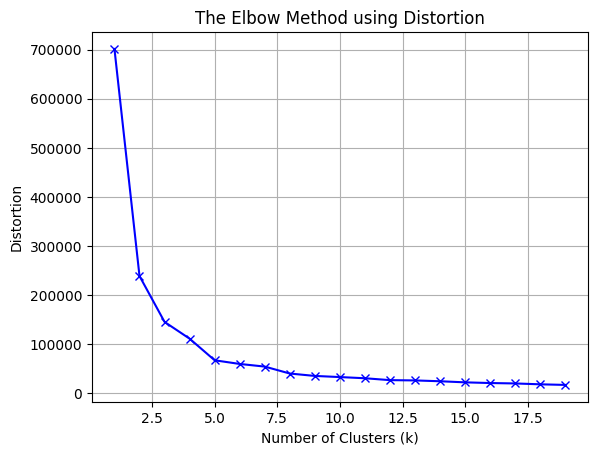

In [55]:
# Fit K-means for different values of k
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

K = range(1, 20)
X = df_agg[[col for col in df_agg.columns if col not in excep_columns]].values
X = X.astype(float)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
    
    # Calculate distortion as the average squared distance from points to their cluster centers
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / X.shape[0])
    
    # Inertia is calculated directly by KMeans
    inertias.append(kmeanModel.inertia_)
    
    # Store the mappings for easy access
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')
# Plotting the graph of k versus Distortion
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.grid()
plt.show()

In [56]:
# clusterer = HDBSCAN()
clusterer = KMeans(n_clusters=7, random_state=2747364364)
clusterer.fit(X=df_agg[[col for col in df_agg.columns if col not in excep_columns]])

KMeans(n_clusters=7, random_state=2747364364)

In [57]:
df_agg["cluster"] = [f"cluster_{cluster}"for cluster in clusterer.labels_]
df_agg["day_name"] = df_agg["Fecha"].dt.day_name()

In [58]:
df_agg.cluster.nunique()

7

In [59]:
# with open("")

df_agg.groupby("cluster").agg({"Fecha": lambda x : list(x)}).to_dict()

{'Fecha': {'cluster_0': [Timestamp('2024-01-01 00:00:00'),
   Timestamp('2024-01-02 00:00:00'),
   Timestamp('2024-02-08 00:00:00'),
   Timestamp('2024-02-28 00:00:00'),
   Timestamp('2024-04-23 00:00:00'),
   Timestamp('2024-04-24 00:00:00'),
   Timestamp('2024-04-25 00:00:00'),
   Timestamp('2024-04-26 00:00:00'),
   Timestamp('2024-04-27 00:00:00'),
   Timestamp('2024-04-28 00:00:00'),
   Timestamp('2024-04-29 00:00:00'),
   Timestamp('2024-04-30 00:00:00'),
   Timestamp('2024-05-01 00:00:00'),
   Timestamp('2024-05-02 00:00:00'),
   Timestamp('2024-05-03 00:00:00'),
   Timestamp('2024-05-04 00:00:00'),
   Timestamp('2024-05-05 00:00:00'),
   Timestamp('2024-05-06 00:00:00'),
   Timestamp('2024-05-07 00:00:00'),
   Timestamp('2024-05-08 00:00:00'),
   Timestamp('2024-05-09 00:00:00'),
   Timestamp('2024-05-10 00:00:00'),
   Timestamp('2024-05-11 00:00:00'),
   Timestamp('2024-05-12 00:00:00'),
   Timestamp('2024-05-13 00:00:00'),
   Timestamp('2024-05-14 00:00:00'),
   Timestamp('20

In [60]:
df_agg.groupby("cluster").agg({"Fecha": "count"}).to_dict()

{'Fecha': {'cluster_0': 97,
  'cluster_1': 21,
  'cluster_2': 55,
  'cluster_3': 6,
  'cluster_4': 38,
  'cluster_5': 87,
  'cluster_6': 11}}

In [61]:
import plotly.express as px
import plotly.graph_objects as go

In [62]:
fig = px.bar(
    data_frame=df_agg,
    x="Fecha",
    y="TOTAL_GEN",
    color="cluster",
    color_discrete_sequence=px.colors.qualitative.Set1,
    # hover_data=["week_of_year", "day_of_week", "is_holiday", "day_name"],
)
fig.add_traces(
    [
        go.Scatter(
            x=df_agg["Fecha"],
            y=df_agg["TERMICA"],
            mode='lines',
            line=dict(color='black', width=1),
            name="Termica",
        ),
        go.Scatter(
            x=df_agg["Fecha"],
            y=df_agg["HIDRAULICA"],
            mode='lines',
            line=dict(color='#ed6f1c', width=1),
            name="hidro",
        ),
    ]
)


fig.show()

In [63]:
df_agg

,Fecha,COGENERADOR,EOLICA,HIDRAULICA,SOLAR,TERMICA,TOTAL_GEN,day_of_week,winter,precio_bolsa_max,precio_bolsa_mean,precio_bolsa_min,cluster,day_name
0,2024-01-01,0.357159,0.473795,143.842059,6.384629,25.095855,176.153496,0,0,301.23,222.175000,95.85,cluster_0,Monday
1,2024-01-02,0.562877,0.423688,162.277078,6.947628,36.476359,206.687629,1,0,449.32,383.636667,284.32,cluster_0,Tuesday
2,2024-01-03,1.179331,0.391955,165.103787,7.424881,40.746649,214.846603,2,0,514.49,462.115000,429.49,cluster_5,Wednesday
3,2024-01-04,1.437006,0.482436,160.142832,7.443663,49.891661,219.397599,3,0,602.95,557.655417,448.95,cluster_5,Thursday
4,2024-01-05,1.818278,0.650878,159.304710,7.135847,52.357767,221.267481,4,0,650.50,623.372500,609.50,cluster_2,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2024-11-06,2.037827,0.154240,135.540676,10.596309,81.655180,229.984233,2,1,2675.80,1870.212500,657.53,cluster_1,Wednesday
311,2024-11-07,2.163911,0.209965,122.445765,8.025633,96.734757,229.580032,3,1,2459.55,1894.958333,1450.04,cluster_6,Thursday
312,2024-11-08,2.359247,0.034563,121.533616,6.633570,94.627672,225.188668,4,1,2128.30,1546.797500,1000.01,cluster_1,Friday
313,2024-11-09,2.734738,0.077343,115.051865,10.482164,84.456442,212.802552,5,1,1490.76,782.156667,700.76,cluster_4,Saturday


In [68]:
fig = px.scatter(
    data_frame=df_agg,
    y="HIDRAULICA",
    x="TERMICA",
    color="cluster",
    size="precio_bolsa_mean",
    color_discrete_sequence=px.colors.qualitative.Plotly,
    hover_data=["day_of_week", "day_name"],
)
fig.show()

In [72]:
centers = pd.DataFrame(
    data=clusterer.cluster_centers_,
    columns=[col for col in df_agg.columns if col not in excep_columns + ["cluster", "day_name"]],
    index=range(clusterer.n_clusters)
)
centers
df_agg["HIDRO_ERROR"] = df_agg.apply(
    lambda x: (x["HIDRAULICA"] - centers.loc[int(x["cluster"].split("_")[1]), "HIDRAULICA"])**2, axis=1
)
df_agg["TERMICA_ERROR"] = df_agg.apply(
    lambda x: (x["TERMICA"] - centers.loc[int(x["cluster"].split("_")[1]), "TERMICA"])**2, axis=1
)
df_agg["TOTAL_ERROR"] = df_agg["HIDRO_ERROR"] + df_agg["TERMICA_ERROR"]
min_error_dates = df_agg.loc[df_agg.groupby("cluster")["TOTAL_ERROR"].idxmin(), ["cluster", "Fecha", "TOTAL_ERROR"]]
min_error_dates

,cluster,Fecha,TOTAL_ERROR
173,cluster_0,2024-06-22,3.631186
309,cluster_1,2024-11-05,1.261795
234,cluster_2,2024-08-22,42.100919
306,cluster_3,2024-11-02,11.042631
95,cluster_4,2024-04-05,19.651607
35,cluster_5,2024-02-05,5.461683
289,cluster_6,2024-10-16,1.285516
